In [24]:
import json
import pandas as pd
import numpy as np
from yome import Session
from yome.models import *
from yome.util import to_df, report
import re
from sqlalchemy.orm import aliased
import itertools as it
import seaborn as sns

In [147]:
pd.set_option('display.max_colwidth', -1)

In [148]:
from mpl_recipes import mpl_setup
%mpl_setup

Populating the interactive namespace from numpy and matplotlib


In [171]:
sns.set_style('ticks')

In [149]:
session = Session()

# Genes without b-number

In [150]:
# Genes b4309 pseudo in EcoGene
no_b_number = to_df(
    session.query(KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('kb_name'))
    .join(Knowledgebase)
    .filter(KnowledgebaseGene.gene_id == None)
)

In [151]:
no_b_number.groupby('kb_name').agg('count')

,primary_name,annotation_quality
kb_name,,
EcoCyc,55,55
UniProt,1,1


# Find locus tags with multiple genes

In [152]:
KnowledgebaseGene2 = aliased(KnowledgebaseGene)

In [153]:
duplicates = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene2.primary_name.label('primary_name2'),
                  Knowledgebase.name)
    .join(KnowledgebaseGene, KnowledgebaseGene.gene_id == Gene.id)
    .join(KnowledgebaseGene2, KnowledgebaseGene2.gene_id == Gene.id)
    .join(Knowledgebase, KnowledgebaseGene.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene2.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene.id != KnowledgebaseGene2.id)
)

In [154]:
duplicates

,locus_id,primary_name,primary_name2,name
0,b3504,yhiS_2,yhiS_1,EcoCyc
1,b0240,crl_1,crl_2,EcoCyc
2,b0240,crl_2,crl_1,EcoCyc
3,b3504,yhiS_1,yhiS_2,EcoCyc
4,b4581,ybeM,ybeH,UniProt
5,b4581,ybeH,ybeM,UniProt


# Kbase comparison plot
NOTE: 55 EcoCyc & 1 UniProt genes without a locus tag and 2 EcoCyc and 1 Uniprot genes with duplicated locus tags are ignored in this plot

In [155]:
kbases = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('knowledgebase_name'))
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
)

In [156]:
# remove duplicate genes
kbases_unstacked = kbases.set_index(['locus_id', 'knowledgebase_name'])
kbases_unstacked = kbases_unstacked[~kbases_unstacked.index.duplicated(keep='first')]
kbases_unstacked = kbases_unstacked.drop('primary_name', axis=1).unstack()
kbases_unstacked.columns = kbases_unstacked.columns.droplevel(0)

In [157]:
# Y-ome counts
kbases_unstacked['Y-ome'].value_counts()

high        2783
low         1564
excluded    306 
Name: Y-ome, dtype: int64

In [158]:
# get list of genes starting with y in EcoCyc
# high quality EcoCyc evidence should override everything, e.g. b0089 / ftsW 

In [159]:
ecocyc_names = {x[0]: x[1] for x in (
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'EcoCyc')
).all()}

In [160]:
def starts_y(row):
    primary_name = ecocyc_names.get(row.name, None)
    return 'low' if primary_name and primary_name.startswith('y') \
        else 'high' if primary_name \
        else None

In [161]:
kbases_unstacked['Starts with "y"'] = kbases_unstacked.apply(starts_y, axis=1)

In [162]:
levels = {
    None: -1,
    'excluded': 0,
    'tbd': 1,
    'low': 2,
    'high': 3,
}

In [163]:
kbases_plot = kbases_unstacked.applymap(lambda x: levels[x])

In [164]:
colors = {
    0: [ 0.85453713,  0.22957019,  0.27623218,  1.        ], # bright red
    1: [ 0.9170408 ,  0.56061475,  0.58722664,  1.        ], # red
    2: [ 0.57653009,  0.72175186,  0.76633449,  1.        ], # light blue green
    3: [ 0.24715576,  0.49918708,  0.57655991,  1.        ], # dark blue green
    -1: [ 0.6,         0.6,         0.6,         1.        ], # grey
}
# pal = sns.diverging_palette(10, 220, sep=80, n=7)
# sns.palplot(pal)
# pal

In [165]:
def make_bars(df_all, labels):
    df = df_all[labels].sort_values(by=labels)
    # create bars based on consecutive colors
    last_value = {kbase: None for kbase in labels}
    bars = {kbase: [] for kbase in labels}
    for locus_tag, row in df.iterrows():
        for kbase, value in row.iteritems():
            if len(bars[kbase]) == 0 or bars[kbase][-1]['value'] != value:
                bars[kbase].append({'value': value, 'height': 1})
                last_value[kbase] = value
            else:
                bars[kbase][-1]['height'] += 1
    return [bars[x] for x in labels]

In [298]:
def plot_bars(bars, labels, figsize=(11, 11), text=False):
    fig, ax = plt.subplots(figsize=figsize)
    last_heights = [0 for _ in labels]
    for bar_list in it.zip_longest(*bars):
        left = [x + 0.1 for x in range(len(labels))]
        height = [x['height'] if x is not None else 0 for x in bar_list]
        bottom = last_heights
        last_heights = [x + y for x, y in zip(height, last_heights)]
        color = [colors[x['value']] if x is not None else 'k' for x in bar_list]
        ax.bar(left, height, bottom=bottom, color=color)
        if text:
            for l, h, b in zip(left, height, bottom):
                if h > 0 and h < 50:
                    y = h / 2 + b
                    ax.annotate(h, xy=(l + 0.15, y), xytext=(l + 0.45, y + 120),
                                arrowprops=dict(facecolor='black', width=1, headwidth=7),
                                verticalalignment='center',
                                color=(0.2,0.2,0.2))
                elif h > 50:
                    y = h + b - (110 if h > 120 else 80 if h > 100 else 30)
                    ax.text(l, y, str(h), horizontalalignment='center', 
                            color=(0.2,0.2,0.2))
    ax.set_xlabel('Knowledgebase')
    ax.set_ylabel('Gene')
    ax.xaxis.set_ticks([x + 0.1 for x in range(len(labels))])
    ax.xaxis.set_ticklabels(labels)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    return fig, ax

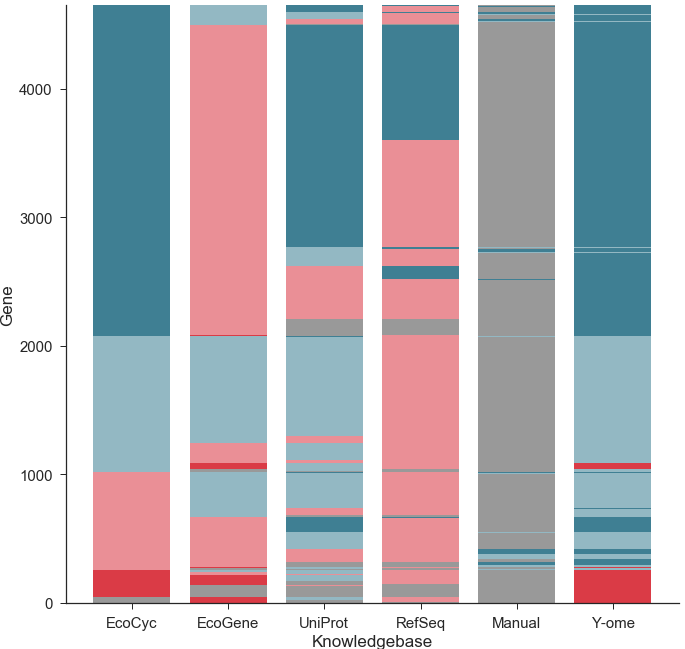

In [299]:
labels = ['EcoCyc', 'EcoGene', 'UniProt', 'RefSeq', 'Manual', 'Y-ome']
kbase_bars = make_bars(kbases_plot, labels)
fig, _ = plot_bars(kbase_bars, labels)
fig.savefig('/Users/zaking/lab/y-ome/figs/kbase-bars.pdf')

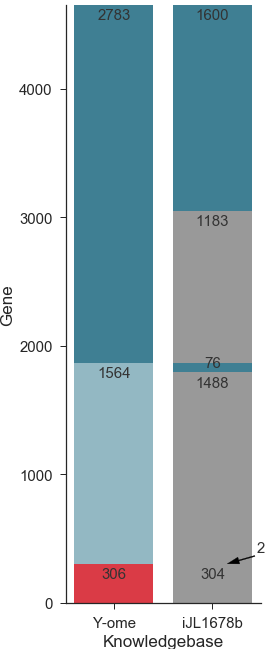

In [300]:
labels = ['Y-ome', 'iJL1678b']
bars = make_bars(kbases_plot, labels)
fig, _ = plot_bars(bars, labels, figsize=(3.5, 11), text=True)
fig.savefig('/Users/zaking/lab/y-ome/figs/me-model-bars.pdf')

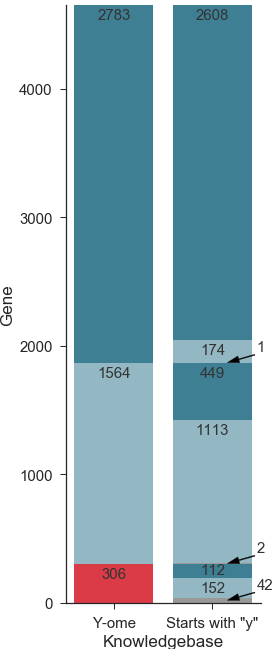

In [301]:
labels = ['Y-ome', 'Starts with "y"']
bars = make_bars(kbases_plot, labels)
fig, _ = plot_bars(bars, labels, figsize=(3.5, 11), text=True)
fig.savefig('/Users/zaking/lab/y-ome/figs/starts-y-bars.pdf')

# cases to check:

### High in one DB, low in another

+ High in EcoCyc and low in EcoGene
  + result: based on *caiC*, give "high" priority over "low" because EcoCyc has more up-to-date information for "high" cases
+ High in UniProt and low in EcoCyc
  + result: based on *yadI / b0129*, don't rely on EC number in UniProt; use annotation score instead
  + result: based on *mrdB*, don't categorize "family protein" as poor annotation in EcoCyc
  + result: based on *YdcE / b1461*, UniProt high should override EcoCyc because EcoCyc missed the experimental validation in the linked paper (good example for the text)
  + result: based on *dgcJ / b1786*, uniprot level 5 annotation should be "low", because even putative functions are given this level of annotation (also a good example for the text)
+ High in ME-model, low in EcoCyc
  + result: ME-model includes putative annotations (e.g. YaaJ). Don't mark these as high
  + TODO provide an analysis of them in the text
+ High in EcoCyc and low in UniProt
  + result: based on thrL; UniProt got this one wrong, should be high
+ dicuss how to prefer b0240 / crl to `_1` and `_2` 
  + https://biocyc.org/gene?orgid=ECOLI&id=G0-16683
  + https://biocyc.org/gene?orgid=ECOLI&id=G0-16684
  + https://biocyc.org/gene?orgid=ECOLI&id=EG11092
  + one solution: devote a paragraph to the discussin in https://biocyc.org/gene?orgid=ECOLI&id=EG11092, noting that UniProt marks this one as "high", and EcoCyc marks it as a pseudogene even though there is a clear function
+ consider EcoCyc 'family protein' as a low keyword
  + result: would only have re-categorized fepE / b0587

### Other E. coli evidence tags

+ "gene expression analysis" is promising, but a number of transcription factors in E. coli have this evidence, but do not have known conditions of binding or binding targets. E.g. yeiL / b2163 and adiY / b4116
+ "inferred by functional complementation" is used with poorly characterized genes like b2952 / yggT
+ "binding of purified proteins" doesn't catch anything new
+ "Inferred from genetic interaction" will get b0461 wrong
+ "Author hypothesis" is too vague
+ "inferred from mutant phenotype" appears on lots of poorly annotated genes, e.g. dctR / b3507
+ 'phage or prophage related' in EcoGene does not mean uncharacterized. e.g. icd / b1136

### Genes where Y-ome disagrees with EcoCyc

Result: After spot-checking a number of cases where EcoCyc is not in agreement with the final Y-ome:

- pseudogenes called by EcoGene are just listed as poorly characterized genes in EcoCyc (OK)
- UniProt gives annotation scores to help clarify annotation for a number of genes. These are present and annotated in EcoCyc, but the annotation level cannot be determined automatically (OK)

### TODO bring in regulonDB


## Assertions
The literature points to a particular answer for these genes

In [484]:
assertions = pd.read_table('../sources/manual/manual.tsv', sep='\t', index_col='locus_tag')

# these differences check out
ok = ['b0268', 'b1695', 'b2844', 'b0240', 'b4453']

# Check for any incorrect assertions
def check_for_row(row):
    return any(row.name == locus_tag and row['Y-ome'] != val and row['Y-ome'] != 'tbd' and val != 'read' and locus_tag not in ok
               for locus_tag, val in assertions.new_qual.iteritems())
res = kbases_unstacked[kbases_unstacked.apply(check_for_row, axis=1)]
print(res)
assert(len(res) == 0)

Empty DataFrame
Columns: [EcoCyc, EcoGene, RefSeq, RegulonDB, UniProt, iJL1678b, Y-ome, starts_y]
Index: []


In [485]:
tbd = kbases_unstacked[(kbases_unstacked['Y-ome'] == 'tbd') & ~kbases_unstacked.index.isin(assertions.index)]
tbd_locus_tag = tbd.index[1]
print(f'{len(tbd)} genes; next locus: {tbd_locus_tag}')

kbases_unstacked[kbases_unstacked.index == tbd_locus_tag]

IndexError: index 1 is out of bounds for axis 0 with size 0

In [486]:
tbd

knowledgebase_name,EcoCyc,EcoGene,RefSeq,RegulonDB,UniProt,iJL1678b,Y-ome,starts_y
locus_id,,,,,,,,


# check on evidence type

In [175]:
ev = to_df(
    session.query(
        Gene.locus_id,
        KnowledgebaseGene.primary_name,
        KnowledgebaseFeature.feature,
    )
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoCyc')
    .filter(KnowledgebaseFeature.feature_type == 'description')
    .filter(KnowledgebaseFeature.feature.ilike('%domain-containing protein%'))
)

In [176]:
evm = ev.merge(kbases_unstacked, left_on='locus_id', right_index=True) #['Y-ome'].value_counts()
evm[evm['Y-ome'] == 'tbd']

,locus_id,primary_name,feature,EcoCyc,EcoGene,RefSeq,RegulonDB,UniProt,iJL1678b,Y-ome,starts_y
39,b1088,yceD,DUF177 domain-containing protein YceD,tbd,tbd,tbd,None,tbd,None,tbd,low
145,b2144,sanA,DUF218 domain-containing protein SanA,tbd,tbd,tbd,None,tbd,None,tbd,high
150,b3362,yhfG,DUF2559 domain-containing protein YhfG,high,low,tbd,None,low,None,tbd,low


In [177]:
report('b0240')

locus_id        b0240
primary_name    crl_1
Name: 0, dtype: object


ValueError: style is not supported for non-unique indicies.